In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Đường dẫn tới dữ liệu
train_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/train'
test_dir = '/content/drive/MyDrive/ỨNG DỤNG HỌC MÁY PHÁT HIỆN  ẢNH GIẢ TRONG LĨNH VỰC  BẢO HIỂM Ô TÔ/Insurance-Fraud-Detection/test'

# Augmentation cho tập train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

# Chỉ rescale cho tập test
test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2230 images belonging to 2 classes.
Found 857 images belonging to 2 classes.


# Mục mới

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import mô hình ResNet50V2
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load mô hình nền
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Đóng băng layer pre-trained

# Thêm các layer đầu ra
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile mô hình
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Xử lý mất cân bằng dữ liệu
from sklearn.utils import class_weight
import numpy as np

train_labels = train_gen.classes
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(train_labels),
                                             y=train_labels)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(3.69205298013245), 1: np.float64(0.5783195020746889)}


In [ ]:
# Huấn luyện mô hình
model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 806s 11s/step - accuracy: 0.5348 - loss: 0.7685 - val_accuracy: 0.6628 - val_loss: 0.6396
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 583s 8s/step - accuracy: 0.6940 - loss: 0.5475 - val_accuracy: 0.7666 - val_loss: 0.5026
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 631s 9s/step - accuracy: 0.7585 - loss: 0.5000 - val_accuracy: 0.7643 - val_loss: 0.5008
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 590s 8s/step - accuracy: 0.7997 - loss: 0.4568 - val_accuracy: 0.7783 - val_loss: 0.4933
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 583s 8s/step - accuracy: 0.8109 - loss: 0.4141 - val_accuracy: 0.7456 - val_loss: 0.5351
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 626s 9s/step - accuracy: 0.7888 - loss: 0.4137 - val_accuracy: 0.8308 - val_loss: 0.4236
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 626s 9s/step - accuracy: 0.8164 - loss: 0.3965 - val_accuracy: 0.8355 - val_loss: 0.4209
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 580s 8s/step - accuracy: 0.8642 - loss: 0.3411 - val_accuracy: 0.8436 - 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

test_gen.reset()
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = test_gen.classes

print("[Classification Report]")
#print(classification_report(y_true, y_pred, target_names=["real", "fake"]))
print(classification_report(y_true, y_pred, target_names=["fake", "real"]))

print("[Confusion Matrix]")
print(confusion_matrix(y_true, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 161s 6s/step
[Classification Report]
              precision    recall  f1-score   support

        fake       0.59      0.55      0.57       157
        real       0.90      0.91      0.91       700

    accuracy                           0.85       857
   macro avg       0.74      0.73      0.74       857
weighted avg       0.84      0.85      0.84       857

[Confusion Matrix]
[[ 86  71]
 [ 61 639]]


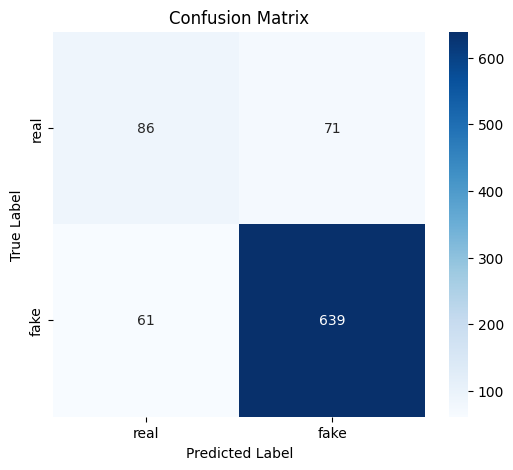

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
labels = ['real', 'fake']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

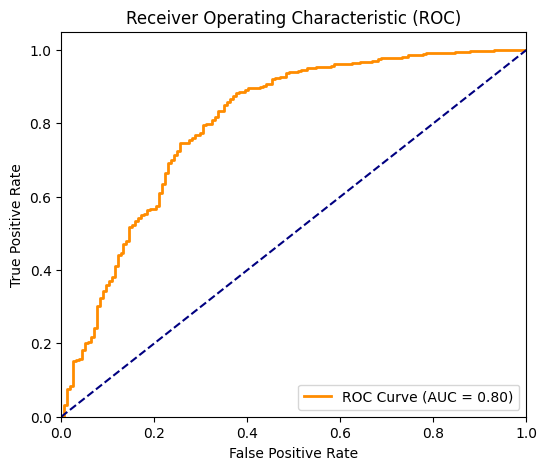

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()